In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import re
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['figure.figsize'] = (10, 6)

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [6]:
Y_train = train.Survived

In [7]:
train.drop('Survived', axis=1, inplace=True)

In [8]:
train['is_test'] = 0
test['is_test'] = 1

In [9]:
df = pd.concat([train, test])
df.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_test
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0


# Немного Feature Engineering'a

In [10]:
# Признак - есть ли данные о каюте
df['Has_Cabin'] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Признак - сколько человек в семье
df['FamilySize'] = df['SibSp'] + df['Parch']

# И отдельный признак - одинокий ли человек
for k in df:
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 0, 'IsAlone'] = 1
    
# Разобьем на категории по возрасту и выделим в отдельные признаки    
df['Age_cat'] = 0
df.loc[df['Age'] <= 16,'Age_cat'] = 0
df.loc[(df['Age'] > 16) & (df['Age'] <= 64), 'Age_cat'] = 1
df.loc[df['Age'] > 64, 'Age_cat'] = 2

# Розобьем на категории по префиксу к имени и выделим в отдельные признаки
df['Mr'] = df.Name.str.contains('mr\.', case = False)
df.Mr.replace({True : 1, False : 0},inplace=True)
df['Mrs'] = df.Name.str.contains('mrs.', case=False)
df.Mrs.replace({True:1, False : 0}, inplace=True)
df['Miss'] = df.Name.str.contains('miss\.', case = False)
df.Miss.replace({True : 1, False : 0},inplace=True)
df['Rev'] = df.Name.str.contains('rev\.', case = False)
df.Rev.replace({True : 1, False : 0},inplace=True)
df['Dr'] = df.Name.str.contains('dr\.', case = False)
df.Dr.replace({True : 1, False : 0},inplace=True)
df['Master'] = df.Name.str.contains('master\.', case = False)
df.Master.replace({True : 1, False : 0},inplace=True)
df['Col'] = df.Name.str.contains('col\.', case = False)
df.Col.replace({True : 1, False : 0},inplace=True)    

# Переведем текстовые признаки в числовой вид
df['isMale'] = df.Sex.replace({'male': 1, 'female':0})
df['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)

# Выкинем ненужные признаки и применим get_dummies к категориальным признакам
df.drop(['Sex', 'Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1, inplace=True)
df_dummies = pd.get_dummies(df, columns=['Pclass', 'Embarked', 'Age_cat'])
df_dummies.head(3)    

,Age,SibSp,Parch,Fare,is_test,Has_Cabin,FamilySize,IsAlone,Mr,Mrs,...,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_0.0,Embarked_1.0,Embarked_2.0,Age_cat_0,Age_cat_1,Age_cat_2
0,22.0,1,0,7.2500,0,0,1,0,1,0,...,1,0,0,1,1,0,0,0,1,0
1,38.0,1,0,71.2833,0,1,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
2,26.0,0,0,7.9250,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,1,0


In [11]:
X_train = df_dummies[df_dummies.is_test==0].drop('is_test', axis=1)
X_test = df_dummies[df_dummies.is_test==1].drop('is_test', axis=1)

In [12]:
X_train.head(3)

,Age,SibSp,Parch,Fare,Has_Cabin,FamilySize,IsAlone,Mr,Mrs,Miss,...,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_0.0,Embarked_1.0,Embarked_2.0,Age_cat_0,Age_cat_1,Age_cat_2
0,22.0,1,0,7.2500,0,1,0,1,0,0,...,1,0,0,1,1,0,0,0,1,0
1,38.0,1,0,71.2833,1,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
2,26.0,0,0,7.9250,0,0,1,0,0,1,...,0,0,0,1,1,0,0,0,1,0


# Заполняем пустые значения

In [13]:
from sklearn.preprocessing import Imputer

In [14]:
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)
imputer.fit(X_train)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [15]:
columns = X_train.columns
X_train_imputed = imputer.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columns)
X_train_imputed.shape

(891, 24)

In [16]:
X_test_imputed = imputer.transform(X_test)

In [17]:
X_test_imputed.shape

(418, 24)

Так как работаем с деревом решений - нормализация данных не требуется

# Перебор параметров и обучение модели

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [19]:
param_grid = {'max_features': [None, 10, 12, 14, 16, 18, 20, 22],
              "max_depth": range(1, 8),
              "min_samples_leaf": range(1, 10),
              "max_leaf_nodes": [None, 5, 10, 15, 20],
              }

tree = GridSearchCV(DecisionTreeClassifier(random_state=555), param_grid)

tree.fit(X_train_imputed, Y_train)

print ('Best Score: {:.3f}'.format(tree.best_score_))
print ('Best Params: ', tree.best_params_)

Best Score: 0.841
Best Params:  {'max_depth': 5, 'max_features': 18, 'max_leaf_nodes': 20, 'min_samples_leaf': 3}


In [20]:
model = DecisionTreeClassifier(**tree.best_params_, random_state=555)

In [21]:
clf = model.fit(X_train_imputed, Y_train)

In [22]:
X_train_prediction = clf.predict(X_train_imputed)
X_train_predict_proba = clf.predict_proba(X_train_imputed)

In [23]:
X_train_predict_proba.shape

(891, 2)

# Делаем предсказание для test и готовим файл

In [24]:
Y_test_prediction = clf.predict(X_test_imputed)
Y_test_predict_proba = clf.predict_proba(X_test_imputed)

Titanic_result = pd.DataFrame(test.PassengerId)
Titanic_result['Survived'] = Y_test_prediction
Titanic_result.to_csv('Titanic_result.csv', index = False)

# Feature Importances для нашей модели

''

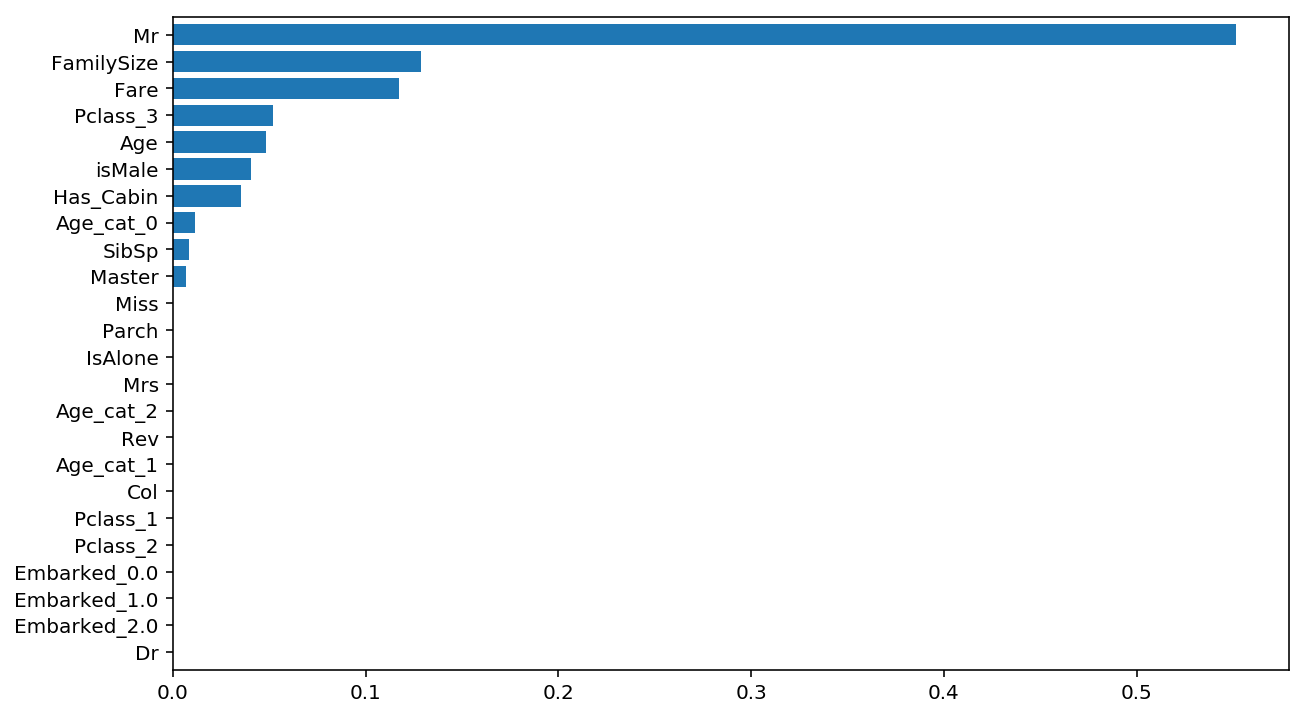

In [25]:
pd.Series(model.feature_importances_, X_train_imputed.columns).sort_values(ascending=True).plot.barh(width=0.8)
''

# Рисуем дерево

In [26]:
from IPython.display import Image
from sklearn.tree import export_graphviz
from pydotplus import graphviz
import pydotplus
from sklearn import tree

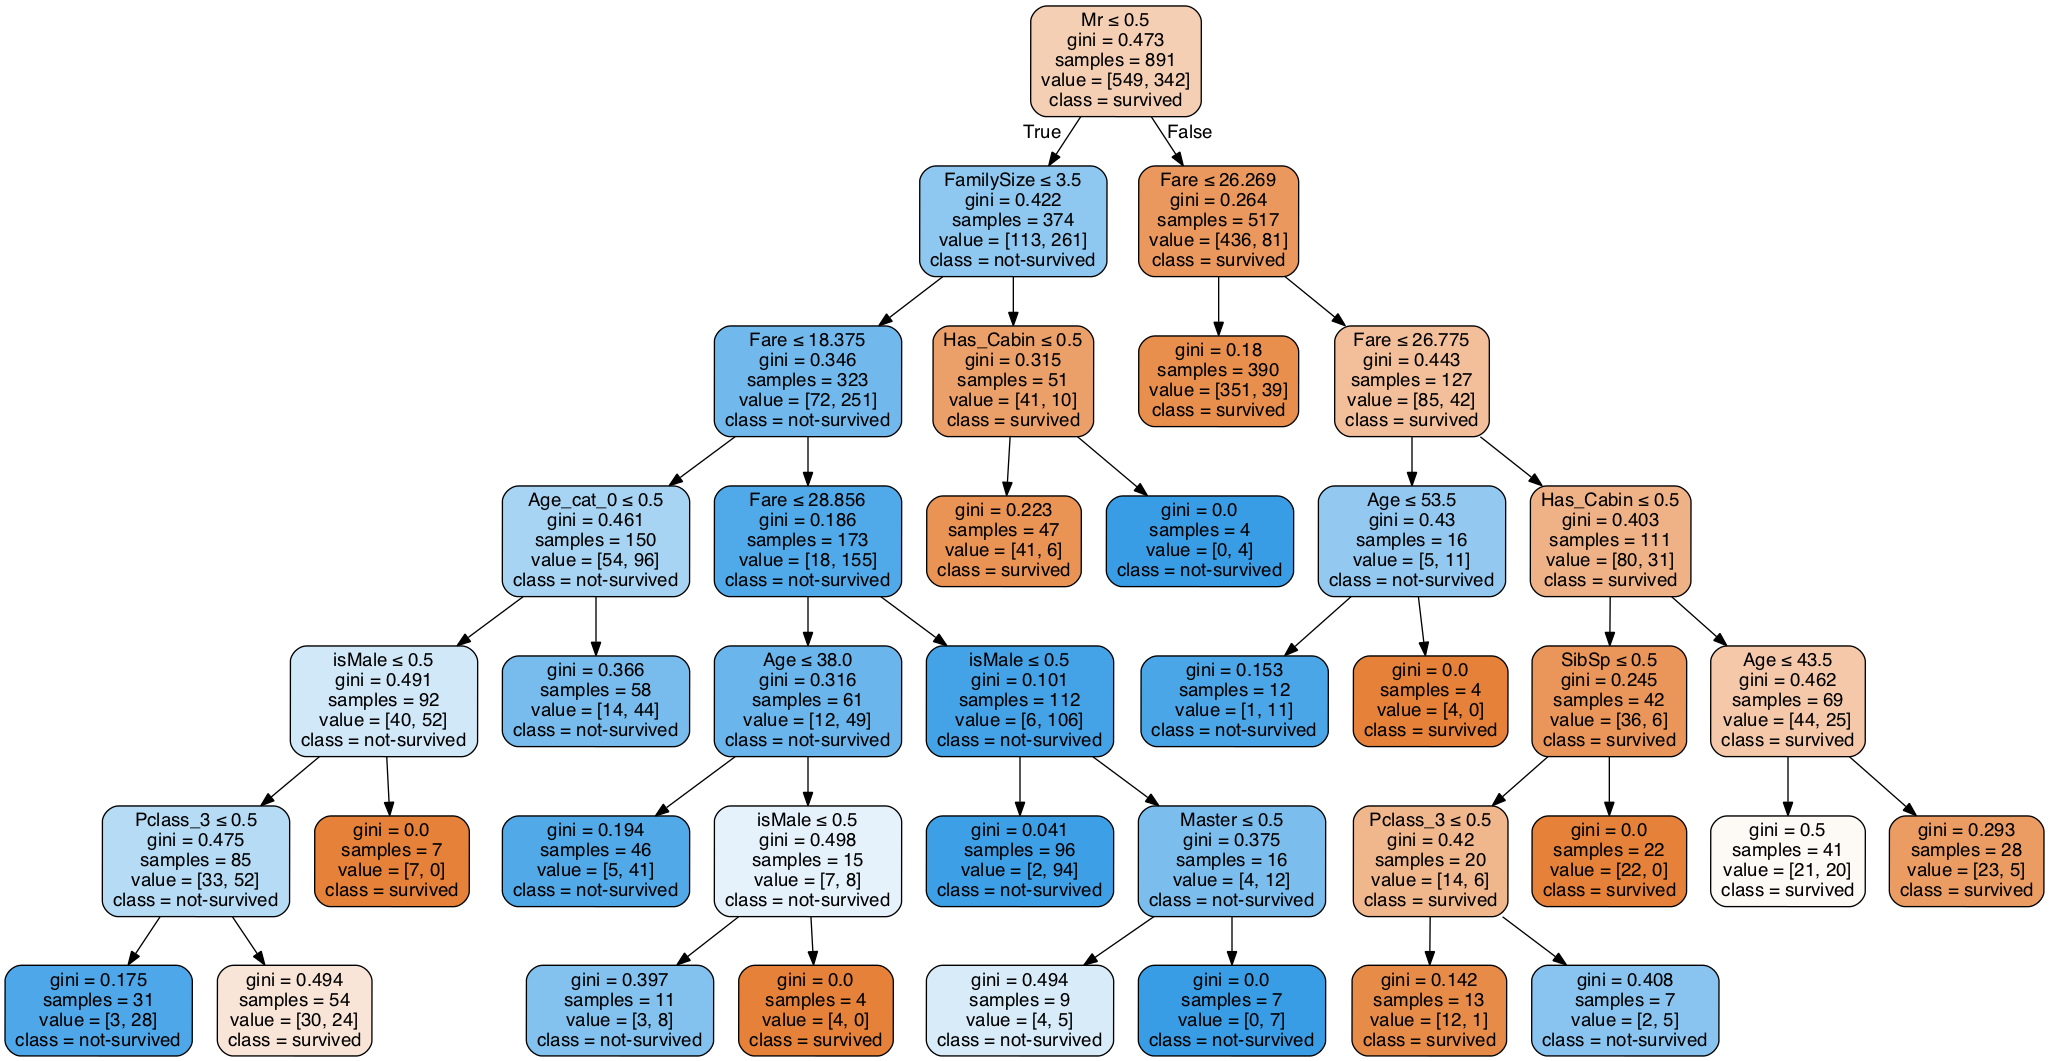

In [27]:

dot_data = tree.export_graphviz(clf, out_file='tree.dot', feature_names=list(X_train_imputed.drop(1)),
                                class_names=['survived','not-survived'], filled=True, rounded=True, 
                                special_characters=True, leaves_parallel=False)
 
graph = pydotplus.graphviz.graph_from_dot_file('tree.dot')
Image(graph.create_png())

# Вычисляем значения ROC-PRC, ROC-AUC

Populating the interactive namespace from numpy and matplotlib


/Users/dmitry/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


''

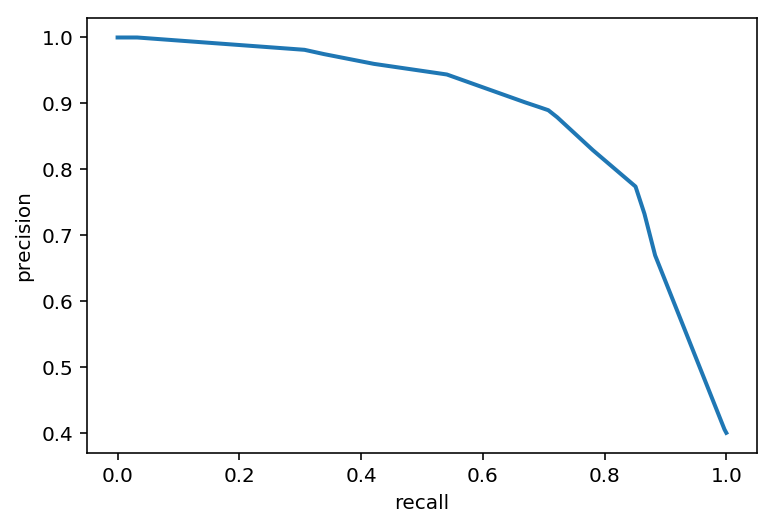

In [28]:
from sklearn.metrics import roc_curve, precision_recall_curve
%pylab inline
# precision и recall
precision, recall, thresholds = precision_recall_curve(Y_train, X_train_predict_proba[:, 1])
plt.plot(recall, precision, linewidth=2.0)
plt.xlabel('recall')
plt.ylabel('precision')
''

In [29]:
from sklearn.metrics import roc_auc_score
# ROC-AUC
roc_auc_score(Y_train, X_train_predict_proba[:, 1] )

0.89939177025745909

# Скрин с Kaggle

![title](Titanic_result_kaggle.png)